In [153]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
np.bool = np.bool_

import mxnet as mx
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import OffsetSplitter
from gluonts.time_feature import TimeFeature
from gluonts.torch.model.tft import TemporalFusionTransformerEstimator
from lightning.pytorch.callbacks import EarlyStopping
from gluonts.evaluation import make_evaluation_predictions, Evaluator

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="The mean prediction is not stored in the forecast data*")

np.random.seed(0)
mx.random.seed(0)

레벨별 분포 가져오기

In [ ]:
level = 2

levels = [
    [],                        # Level 1: Total
    ['state_id'],              # Level 2: State
    ['store_id'],              # Level 3: Store
    ['cat_id'],                # Level 4: Category
    ['dept_id'],               # Level 5: Department
    ['state_id', 'cat_id'],    # Level 6: State-Category
    ['state_id', 'dept_id'],   # Level 7: State-Department
    ['store_id', 'cat_id'],    # Level 8: Store-Category
    ['store_id', 'dept_id'],   # Level 9: Store-Department
    ['item_id'],               # Level 10: Item
    ['item_id', 'state_id'],   # Level 11: Item-State
    ['item_id', 'store_id']    # Level 12: Individual
]

start_date = pd.to_datetime('2011-01-29')
agg_df = pd.read_csv(f'../data/preprocessed/agg_df_level_{level}.csv')
calendar_df = pd.read_csv('../data/preprocessed/calendar_df.csv')

agg_df['d'] = agg_df['d'].apply(lambda x: int(x.split('_')[1]) - 1)
agg_df['d'] = start_date + pd.to_timedelta(agg_df['d'], unit='D')
calendar_df['d'] = calendar_df['d'].apply(lambda x: int(x.split('_')[1]) - 1)
calendar_df['d'] = start_date + pd.to_timedelta(calendar_df['d'], unit='D')

if len(levels[level-1]) ==1:
    agg_df.insert(1, 'id', agg_df[levels[level-1][0]])
elif len(levels[level-1]) > 1:
    agg_df.insert(1, 'id', agg_df[levels[level-1][0]] + '_' + agg_df[levels[level-1][1]])

train_data = []
test_data = []

groups = agg_df[levels[level-1][0]].unique()
group_encoder = {group: idx for idx, group in enumerate(groups)}
for group in groups:
    group_df = agg_df[agg_df[levels[level-1][0]] == group] # 1941 rows
    group_df = group_df.merge(calendar_df, on="d", how="left")
    
    train_data.append({
        FieldName.TARGET: group_df['sales_sum'].values[:1913],
        FieldName.START: start_date,
        FieldName.FEAT_STATIC_CAT: [group_encoder[group]],
        FieldName.FEAT_DYNAMIC_REAL: group_df[[
            "sales_mean", "sales_std", "sales_max", "sales_min", 
            "sales_lag1", "sales_lag7", "sales_lag28",  
            "sales_rolling7_mean", "sales_rolling28_mean", 
            "sales_trend", 
            "release_mean", "out_of_stock_mean", 
            "sell_price_mean", "sell_price_std", "sell_price_max", "sell_price_min", 
            "sell_price_diff", "sell_price_trend", "sell_price_in_store_mean",
            "snap_CA", "snap_TX", "snap_WI",  
            "year_delta", "quarter_sin", "quarter_cos", "month_sin", "month_cos",  
            "day_sin", "day_cos", "weekday_sin", "weekday_cos",
            'event_count'
        ]].values[:1913].T,
        FieldName.FEAT_DYNAMIC_CAT: group_df[[
            'snap_CA', 'snap_TX', 'snap_WI', 
            'event_name_1_enc', 'event_name_2_enc', 'event_type_1_enc', 'event_type_2_enc'
        ]].values[:1913].T,
    })

    test_data.append({
        FieldName.TARGET: group_df['sales_sum'].values,
        FieldName.START: start_date,
        FieldName.FEAT_STATIC_CAT: [group_encoder[group]],
        FieldName.FEAT_DYNAMIC_REAL: group_df[[
            "sales_mean", "sales_std", "sales_max", "sales_min", 
            "sales_lag1", "sales_lag7", "sales_lag28",  
            "sales_rolling7_mean", "sales_rolling28_mean", 
            "sales_trend", 
            "release_mean", "out_of_stock_mean", 
            "sell_price_mean", "sell_price_std", "sell_price_max", "sell_price_min", 
            "sell_price_diff", "sell_price_trend", "sell_price_in_store_mean",
            "snap_CA", "snap_TX", "snap_WI",  
            "year_delta", "quarter_sin", "quarter_cos", "month_sin", "month_cos",  
            "day_sin", "day_cos", "weekday_sin", "weekday_cos",
            'event_count'
        ]].values.T,
        FieldName.FEAT_DYNAMIC_CAT: group_df[[
            'snap_CA', 'snap_TX', 'snap_WI', 
            'event_name_1_enc', 'event_name_2_enc', 
            'event_type_1_enc', 'event_type_2_enc'
        ]].values.T,
    })

train_dataset = ListDataset(train_data, freq="D")
test_dataset = ListDataset(test_data, freq="D")

In [154]:
epochs = 1
lr = 1e-3
batch_size = 64

quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
evaluator = Evaluator(quantiles=quantiles)

estimator = TemporalFusionTransformerEstimator(
    freq="D",
    context_length=28,
    prediction_length=28,
    quantiles=quantiles,

    hidden_dim=64,
    num_heads=4,
    dropout_rate=0.1,

    static_cardinalities=[len(groups)],
    dynamic_dims=[32],
    dynamic_cardinalities=[2, 2, 2, 
                           31, 31, 
                           5, 5],

    trainer_kwargs={
        "max_epochs": epochs, 
        "accelerator": "auto",
    },
    lr = lr,
    batch_size = batch_size,
)

predictor = estimator.train(train_dataset)

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset,
    predictor=predictor,
)

forecasts = list(forecast_it)
tss = list(ts_it)

agg_metrics, item_metrics = evaluator(tss, forecasts)

for metric, value in agg_metrics.items():
    print(f"{metric}: {value:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type                           | Params | Mode  | In sizes                                                                            | Out sizes                     
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 308 K  | train | [[1, 28], [1, 28], [1, 1], [1, 1], [1, 56, 35], [1, 56, 7], [1, 28, 0], [1, 28, 0]] | [[[1, 28, 9]], [1, 1], [1, 1]]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
308 K     Trainable params
0         Non-trainable params
308 K     Total params
1.235     Total estimated model params size (MB)


Epoch 0: |          | 50/? [00:06<00:00,  7.47it/s, v_num=4, train_loss=215.0]

Epoch 0, global step 50: 'train_loss' reached 215.29575 (best 215.29575), saving model to 'c:\\Users\\USER\\Desktop\\Git\\sci 2\\SCI_Journal_2\\code\\lightning_logs\\version_4\\checkpoints\\epoch=0-step=50.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: |          | 50/? [00:06<00:00,  7.40it/s, v_num=4, train_loss=215.0]


The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data;


Aggregate Metrics:
MSE: 248154.9170
abs_error: 102364.2705
abs_target_sum: 1231764.0000
abs_target_mean: 4399.1571
seasonal_error: 510.7020
MASE: 0.7421
MAPE: 0.0800
sMAPE: 0.0804
MSIS: 4.9904
num_masked_target_values: 0.0000
QuantileLoss[0.005]: 5093.7417
Coverage[0.005]: 0.0000
QuantileLoss[0.025]: 15463.8375
Coverage[0.025]: 0.0071
QuantileLoss[0.165]: 66757.1854
Coverage[0.165]: 0.0964
QuantileLoss[0.25]: 81165.1893
Coverage[0.25]: 0.1679
QuantileLoss[0.5]: 102364.2717
Coverage[0.5]: 0.3964
QuantileLoss[0.75]: 87280.5496
Coverage[0.75]: 0.6464
QuantileLoss[0.835]: 69598.8971
Coverage[0.835]: 0.7786
QuantileLoss[0.975]: 19550.0184
Coverage[0.975]: 0.9643
QuantileLoss[0.995]: 7273.5772
Coverage[0.995]: 0.9857
RMSE: 498.1515
NRMSE: 0.1132
ND: 0.0831
wQuantileLoss[0.005]: 0.0041
wQuantileLoss[0.025]: 0.0126
wQuantileLoss[0.165]: 0.0542
wQuantileLoss[0.25]: 0.0659
wQuantileLoss[0.5]: 0.0831
wQuantileLoss[0.75]: 0.0709
wQuantileLoss[0.835]: 0.0565
wQuantileLoss[0.975]: 0.0159
wQuantileL

In [155]:
# n_plot = 2

# group_df = merge_df.groupby('id')
# group_keys = list(group_df.groups.keys())
# indices = np.random.choice(np.arange(0, len(group_keys)), size=n_plot, replace=False)

# forecast_it, test_it = make_evaluation_predictions(dataset=test_dataset, predictor=predictor)
# forecast_data = np.array([forecast.samples for forecast in forecast_it]).transpose(0, 2, 1) # (70, 28, 100)

# fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot * 5))
# for index, ax in zip(indices, axes):
#     group_data = group_df.get_group(group_keys[index])
#     ax.plot(group_data['d'], group_data['sales_sum'])
#     for q in quantiles:
#         quantile_data = np.percentile(forecast_data[index], q * 100, axis=-1)
#         ax.plot(group_data['d'][-28:], quantile_data, label=f'{q*100}% Quantile')
#     ax.set_xlim(group_data['d'].iloc[-4*28], group_data['d'].iloc[-1])
#     ax.set_title(f"{group_keys[index]}")
#     ax.legend(loc="upper left")

# plt.tight_layout()
# plt.show()

계층적 모델

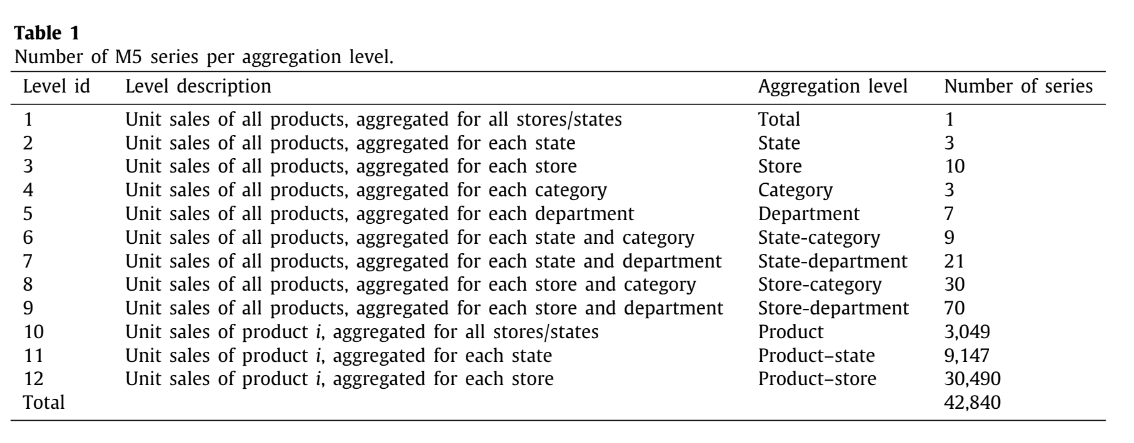

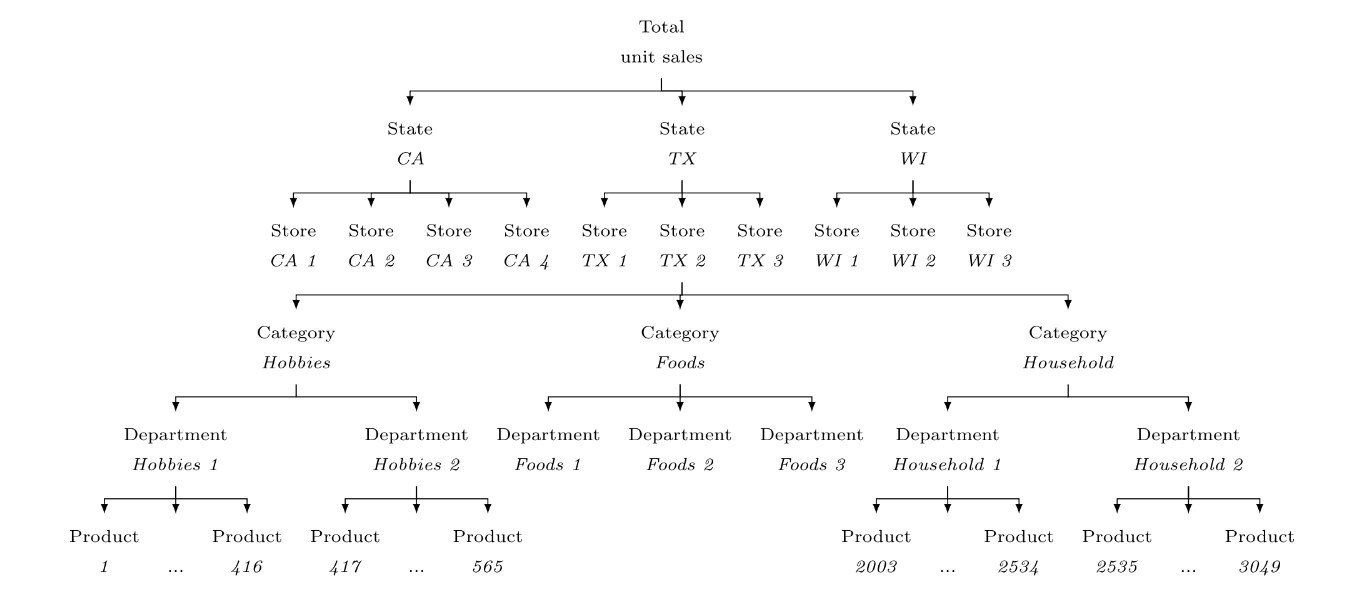

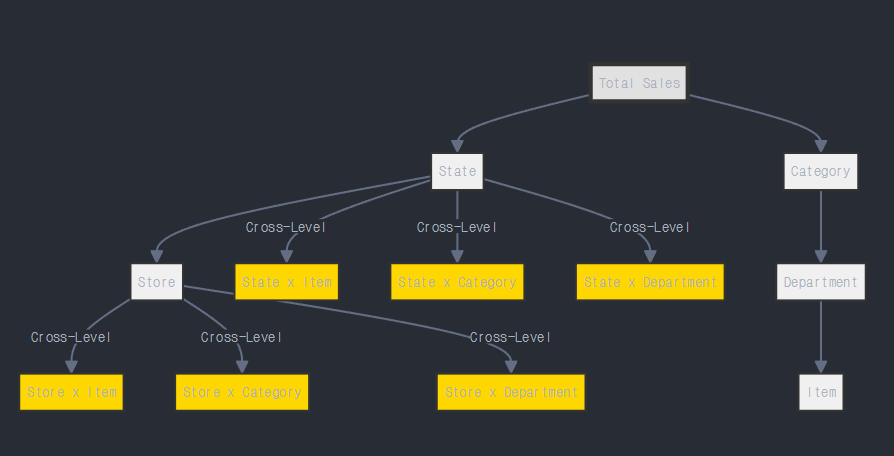
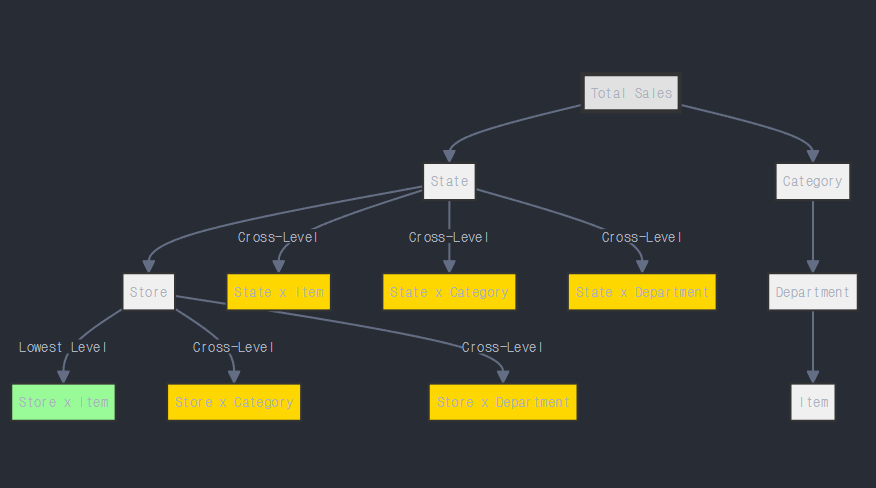
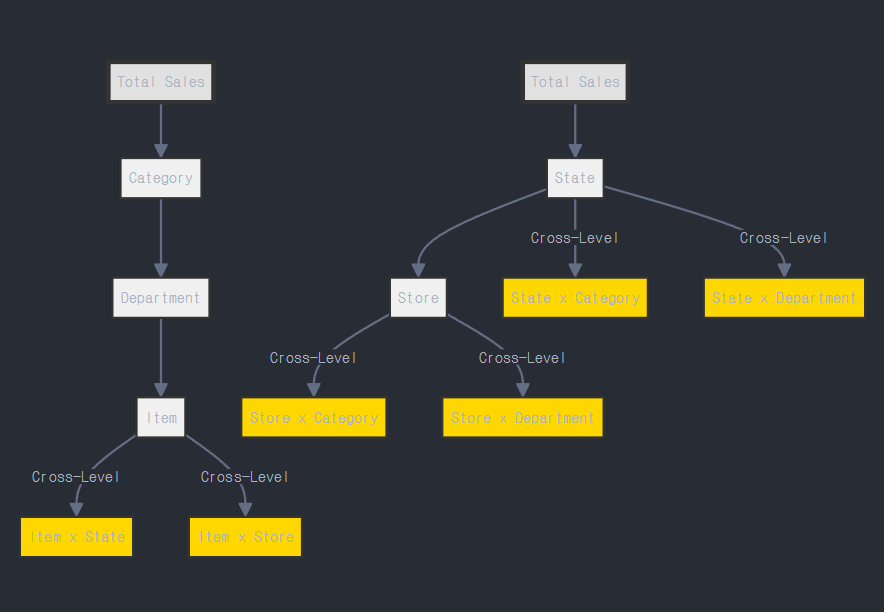

제품 계층 기반 트리 / 위치 계층 기반 트리

단일 레벨 예측 후 단방향 접근 한계 극복

Cross-Level 관계에서 불확실성 전파 

In [ ]:
def prepare_datasets():
    levels = [
        [],                        # Level 1: Total
        ['state_id'],              # Level 2: State
        ['store_id'],              # Level 3: Store
        ['cat_id'],                # Level 4: Category
        ['dept_id'],               # Level 5: Department
        ['state_id', 'cat_id'],    # Level 6: State-Category
        ['state_id', 'dept_id'],   # Level 7: State-Department
        ['store_id', 'cat_id'],    # Level 8: Store-Category
        ['store_id', 'dept_id'],   # Level 9: Store-Department
        ['item_id'],               # Level 10: Item
        ['item_id', 'state_id'],   # Level 11: Item-State
        ['item_id', 'store_id']    # Level 12: Individual
    ]

    datasets = {'train': {}, 'test': {}}
    for level in levels:
        # 데이터 로드
        agg_df = pd.read_csv(f'../data/preprocessed/agg_df_level_{level}.csv')
        calendar_df = pd.read_csv('../data/preprocessed/calendar_df.csv')

        # 날짜 처리
        start_date = pd.to_datetime('2011-01-29')
        agg_df['d'] = agg_df['d'].apply(lambda x: int(x.split('_')[1]) - 1)
        agg_df['d'] = start_date + pd.to_timedelta(agg_df['d'], unit='D')
        calendar_df['d'] = calendar_df['d'].apply(lambda x: int(x.split('_')[1]) - 1)
        calendar_df['d'] = start_date + pd.to_timedelta(calendar_df['d'], unit='D')
        
        # ID 컬럼 생성
        if level == 1:
            agg_df.insert(1, 'id', agg_df[level[0]])
        else:
            agg_df.insert(0, 'id', agg_df[level[0]] + '_' + agg_df[level[1]])
        
        # calendar_df와 병합
        groups = agg_df['id'].unique()
        group_encoder = {group: idx for idx, group in enumerate(groups)}
        
        # GluonTS dataset 생성
        data = []
        for group in groups:
            group_df = agg_df[agg_df[levels[level-1][0]] == group] # 1941 rows
            group_df = group_df.merge(calendar_df, on="d", how="left")

            data.append({
                FieldName.TARGET: group_df['sales_sum'].values,
                FieldName.START: start_date,
                FieldName.FEAT_STATIC_CAT: [group_encoder[group]],
                FieldName.FEAT_DYNAMIC_REAL: group_df[[
                    "sales_mean", "sales_std", "sales_max", "sales_min", 
                    "sales_lag1", "sales_lag7", "sales_lag28",  
                    "sales_rolling7_mean", "sales_rolling28_mean", 
                    "sales_trend", 
                    "release_mean", "out_of_stock_mean", 
                    "sell_price_mean", "sell_price_std", "sell_price_max", "sell_price_min", 
                    "sell_price_diff", "sell_price_trend", "sell_price_in_store_mean",
                    "snap_CA", "snap_TX", "snap_WI",  
                    "year_delta", "quarter_sin", "quarter_cos", "month_sin", "month_cos",  
                    "day_sin", "day_cos", "weekday_sin", "weekday_cos",
                    'event_count'
                ]].values.T,
                FieldName.FEAT_DYNAMIC_CAT: group_df[[
                    'snap_CA', 'snap_TX', 'snap_WI', 
                    'event_name_1_enc', 'event_name_2_enc', 
                    'event_type_1_enc', 'event_type_2_enc'
                ]].values.T,
            })
        dataset = ListDataset(data, freq="D")

        # Train/Test 분할
        test_splitter = OffsetSplitter(offset=1914)
        train_dataset, test_dataset = test_splitter.split(dataset)
        
        datasets['train'][level] = train_dataset
        datasets['test'][level] = test_dataset
    
    return datasets

def train_models(epochs, lr, batch_size):
    # Train/Test 데이터셋 준비
    datasets = prepare_datasets()
    
    # 각 레벨별로 TFT 모델 학습
    models = {}
    preds = {'train': {}, 'test': {}}
    
    for level, train_dataset in datasets['train'].items():
        # 모델 선언
        model = TemporalFusionTransformerEstimator(
                    freq="D",
                    context_length=28,
                    prediction_length=28,
                    quantiles=quantiles,

                    hidden_dim=64,
                    num_heads=4,
                    dropout_rate=0.1,

                    static_cardinalities=[len(groups)],
                    dynamic_dims=[32],
                    dynamic_cardinalities=[2, 2, 2, 
                                        31, 31, 
                                        5, 5],

                    trainer_kwargs={
                        "max_epochs": epochs, 
                        "accelerator": "auto",
                    },
                    lr = lr,
                    batch_size = batch_size,
                )
        
        # 모델 학습
        predictor = estimator.train(train_dataset)

        # 모델 예측
        forecast_it, test_it = make_evaluation_predictions(
            dataset=test_dataset,
            predictor=predictor,
            num_samples=100
        )

        forecasts = list(forecast_it)
        tests = list(test_it)
        agg_metrics, item_metrics = evaluator(tests, forecasts)
        
        train_pred = model.predict(train_dataset)
        test_pred = model.predict(datasets['test'][level])
        
        models[level] = model
        preds['train'][level] = train_pred
        preds['test'][level] = test_pred
    
    return models, preds

train_models(
    epochs = 1,
    lr = 1e-3,
    batch_size = 64
)

AttributeError: 'TemporalFusionTransformerEstimator' object has no attribute 'fit'

In [ ]:
def consistency_loss():
    total_loss = 0
    
    # 1. 계층 구조의 일관성 (흰색 노드들 간의 관계)
    ## Total = State sum = Category sum
    total_loss += abs(total_pred - sum(state_preds))
    total_loss += abs(total_pred - sum(category_preds))
    
    ## State → Store 계층
    for state_id in states:
        state_pred = model.predict_state(state_id)
        stores_in_state = get_stores_in_state(state_id)
        store_sum = sum(model.predict_stores(stores_in_state))
        total_loss += abs(state_pred - store_sum)
    
    ## Category → Department → Item 계층
    for cat_id in categories:
        category_pred = model.predict_category(cat_id)
        departments = get_departments_in_category(cat_id)
        dept_sum = sum(model.predict_departments(departments))
        total_loss += abs(category_pred - dept_sum)
        
        for dept_id in departments:
            dept_pred = model.predict_department(dept_id)
            items = get_items_in_department(dept_id)
            item_sum = sum(model.predict_items(items))
            total_loss += abs(dept_pred - item_sum)
    
    # 2. Cross-Level 관계 (노란색 노드들 간의 관계)
    ## State 기반 Cross-Level
    for state_id in states:
        state_pred = model.predict_state(state_id)
        
        # State의 모든 Cross-Level 관계
        cross_sums = {
            'item': sum(model.predict_state_items(state_id)),
            'category': sum(model.predict_state_categories(state_id)),
            'department': sum(model.predict_state_departments(state_id))
        }
        
        for sum_value in cross_sums.values():
            total_loss += abs(state_pred - sum_value)
    
    ## Store 기반 Cross-Level
    for store_id in stores:
        store_pred = model.predict_store(store_id)
        
        # Store의 모든 Cross-Level 관계
        cross_sums = {
            'item': sum(model.predict_store_items(store_id)),
            'category': sum(model.predict_store_categories(store_id)),
            'department': sum(model.predict_store_departments(store_id))
        }
        
        for sum_value in cross_sums.values():
            total_loss += abs(store_pred - sum_value)
    
    return total_loss

def total_loss():
    # 각 레벨별 예측 손실
    level_losses = (
        total_loss + 
        state_loss + 
        store_loss + 
        category_loss + 
        department_loss + 
        store_category_loss +
        store_department_loss +
        state_category_loss +
        state_department_loss +
        item_loss +
        item_state_loss +
        item_store_loss
    )
    
    # 일관성 제약 손실
    consistency = consistency_loss()
    
    # 가중치를 적용한 최종 손실
    return (
        alpha * level_losses + 
        beta * consistency
    )

In [ ]:
for epoch in range(num_epochs):
    # level 예측
    train_level()
    
    # 전체 모델 업데이트
    total_loss_value = total_loss()
    optimizer.zero_grad()
    total_loss_value.backward()
    optimizer.step()

각 시점 모델 증류 (Decision Tree)